In [1]:
## for data
import pandas as pd
import numpy as np

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

## for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition

In [36]:
dt = pd.read_csv("insurance.csv")
dt.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


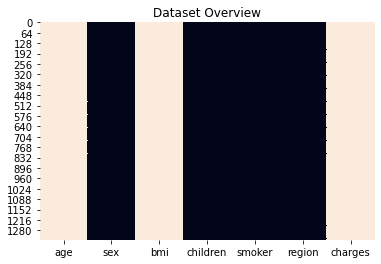

 Categerocial   Numeric   NaN 


In [4]:
def utils_recognize_type(dt, col, max_cat=20):
    if (dt[col].dtype == "O") | (dt[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"
    
dic_cols = {col:utils_recognize_type(dt, col, max_cat=20) for col in dt.columns}
heatmap = dt.isnull()
for k,v in dic_cols.items():
 if v == "num":
   heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
 else:
   heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)

sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
plt.show()
print("\033[1;37;40m Categerocial ", "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")    

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
dt['sex']=le.fit_transform(dt['sex'])
dt['smoker']=le.fit_transform(dt['smoker'])
dt['region']=le.fit_transform(dt['region'])

dt.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


<ipython-input-6-17da7953dd78>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  dt.hist(ax=ax)


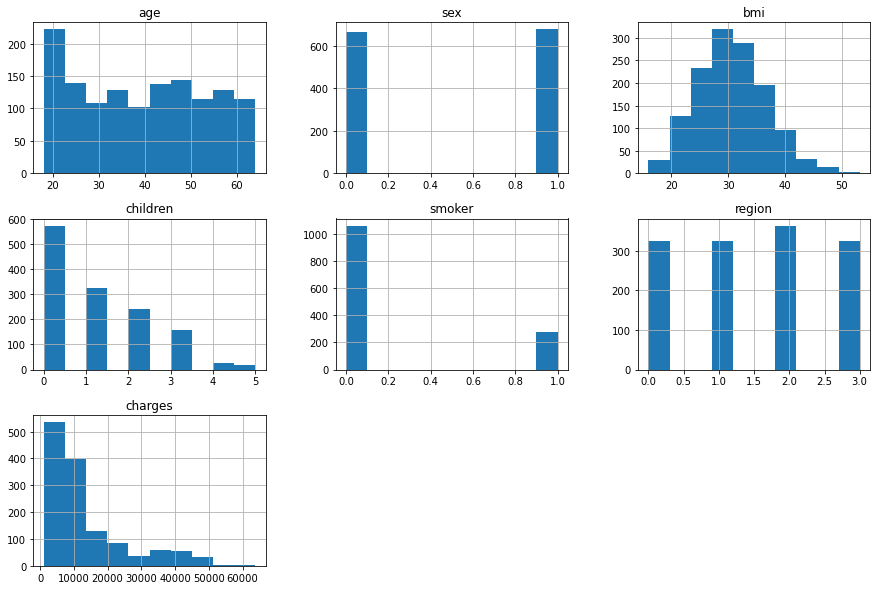

In [6]:
fig=plt.figure(figsize=(15,10))
ax=fig.gca()
dt.hist(ax=ax)
plt.show();

In [7]:
num_vars = ['age', 'bmi']
dt = dt.rename(columns = {"charges": "Y"})
y = "Y"
scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dt[num_vars] = scalerX.fit_transform(dt[num_vars])

## scale Y
scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
dt[y] = scalerY.fit_transform(dt[y].values.reshape(-1,1))
dt.head()

,age,sex,bmi,children,smoker,region,Y
0,-0.833333,0,-0.297708,0,1,3,0.630515
1,-0.875000,1,0.401310,1,0,2,-0.643422
2,-0.458333,1,0.309616,3,0,2,-0.414515
3,-0.250000,1,-0.916344,0,0,1,1.059062
4,-0.291667,1,-0.181006,0,0,1,-0.463475


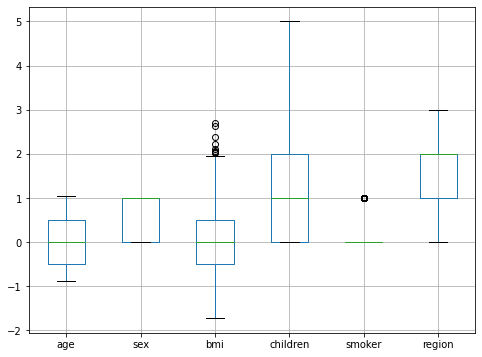

In [8]:
boxplot=dt.drop('Y', axis = 1).boxplot(figsize=(8,6))

<AxesSubplot:xlabel='selection', ylabel='features'>

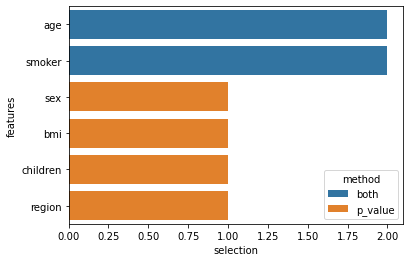

In [9]:
#Feature selection

X = dt.drop("Y", axis=1).values
y = dt["Y"].values
feature_names = dt.drop("Y", axis=1).columns

## p-value
selector = feature_selection.SelectKBest(score_func= feature_selection.f_regression, k=6).fit(X,y)
pvalue_selected_features = feature_names[selector.get_support()]

## regularization
selector = feature_selection.SelectFromModel(estimator = linear_model.Ridge(alpha=1.0, fit_intercept=True), max_features=6).fit(X,y)
regularization_selected_features = feature_names[selector.get_support()]
 
## plot
dt_features = pd.DataFrame({"features":feature_names})
dt_features["p_value"] = dt_features["features"].apply(lambda x: "p_value" if x in pvalue_selected_features else "")
dt_features["num1"] = dt_features["features"].apply(lambda x: 1 if x in pvalue_selected_features else 0)
dt_features["regularization"] = dt_features["features"].apply(lambda x: "regularization" if x in regularization_selected_features else "")
dt_features["num2"] = dt_features["features"].apply(lambda x: 1 if x in regularization_selected_features else 0)
dt_features["method"] = dt_features[["p_value","regularization"]].apply(lambda x: (x[0]+" "+x[1]).strip(), axis=1)
dt_features["selection"] = dt_features["num1"] + dt_features["num2"]
dt_features["method"] = dt_features["method"].apply(lambda x: "both" if len(x.split()) == 2 else x)

sns.barplot(y="features", x="selection", hue="method", data=dt_features.sort_values("selection", ascending=False), dodge=False)

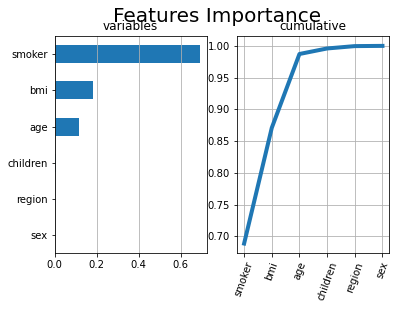

In [10]:
X = dt.drop("Y", axis=1).values
y = dt["Y"].values
feature_names = dt.drop("Y", axis=1).columns.tolist()

## call model
model = ensemble.GradientBoostingRegressor()

## Importance
model.fit(X,y)
importances = model.feature_importances_

## Put in a pandas dtf
dtf_importances = pd.DataFrame({"IMPORTANCE":importances, "VARIABLE":feature_names}).sort_values("IMPORTANCE", ascending=False)
dtf_importances['cumsum'] =  dtf_importances['IMPORTANCE'].cumsum(axis=0)
dtf_importances = dtf_importances.set_index("VARIABLE")
    
## Plot
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fig.suptitle("Features Importance", fontsize=20)
ax[0].title.set_text('variables')
dtf_importances[["IMPORTANCE"]].sort_values(by="IMPORTANCE").plot(kind="barh", legend=False, ax=ax[0]).grid(axis="x")
ax[0].set(ylabel="")
ax[1].title.set_text('cumulative')
dtf_importances[["cumsum"]].plot(kind="line", linewidth=4, legend=False, ax=ax[1])
ax[1].set(xlabel="", xticks=np.arange(len(dtf_importances)), xticklabels=dtf_importances.index)
plt.xticks(rotation=70)
plt.grid(axis='both')
plt.show()

In [11]:
#One way ANOVA Test
cat, num = "sex", 'Y'
model = smf.ols(num+' ~ '+cat, data=dt).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.036)


In [12]:
#One way ANOVA Test
cat, num = "smoker", "Y"
model = smf.ols(num+' ~ '+cat, data=dt).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.0)


In [13]:
#One way ANOVA Test
cat, num = "children", "Y"
model = smf.ols(num+' ~ '+cat, data=dt).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Correlated (p-value: 0.013)


In [14]:
#One way ANOVA Test
cat, num = "region", "Y"
model = smf.ols(num+' ~ '+cat, data=dt).fit()
table = sm.stats.anova_lm(model)
p = table["PR(>F)"][0]
coeff, p = None, round(p, 3)
conclusion = "Correlated" if p < 0.05 else "Non-Correlated"
print("Anova F: the variables are", conclusion, "(p-value: "+str(p)+")")

Anova F: the variables are Non-Correlated (p-value: 0.821)


In [15]:
#Pearson's Correlation Coefficient
x, y = "age", "Y"
dt_noNan = dt[dt[x].notnull()]
coeff, p = scipy.stats.pearsonr(dt_noNan[x], dt_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.299 Significant (p-value: 0.0)


In [16]:
#Pearson's Correlation Coefficient
x, y = "bmi", "Y"
dt_noNan = dt[dt[x].notnull()]
coeff, p = scipy.stats.pearsonr(dt_noNan[x], dt_noNan[y])
coeff, p = round(coeff, 3), round(p, 3)
conclusion = "Significant" if p < 0.05 else "Non-Significant"
print("Pearson Correlation:", coeff, conclusion, "(p-value: "+str(p)+")")

Pearson Correlation: 0.198 Significant (p-value: 0.0)


Text(0.5, 1.0, 'pearson correlation')

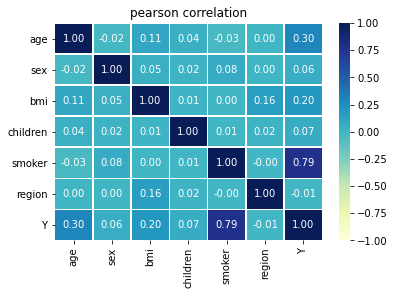

In [17]:
corr_matrix = dt.corr(method="pearson")
sns.heatmap(corr_matrix, vmin=-1., vmax=1., annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("pearson correlation")

In [26]:
## split data
dt_train, dt_test = model_selection.train_test_split(dt, test_size=0.3)
## print info
print("X_train shape:", dt_train.drop("Y",axis=1).shape, "| X_test shape:", dt_test.drop("Y",axis=1).shape)
print("y_train mean:", round(np.mean(dt_train["Y"]),2), "| y_test mean:", round(np.mean(dt_test["Y"]),2))
print(dt_train.shape[1], "features:", dt_train.drop("Y",axis=1).columns.to_list())

X_names = ['smoker','bmi','age','children', 'sex']
X_train = dt_train[X_names]
y_train = dt_train["Y"]
X_test = dt_test[X_names]
y_test = dt_test["Y"]



X_train shape: (936, 6) | X_test shape: (402, 6)
y_train mean: 0.34 | y_test mean: 0.28
7 features: ['age', 'sex', 'bmi', 'children', 'smoker', 'region']


In [27]:
X_train

,smoker,bmi,age,children,sex
1139,1,0.248884,-0.833333,0,0
1215,0,1.040786,-0.875000,0,1
561,0,0.271509,0.625000,0,0
177,0,-0.142900,0.625000,1,1
1011,1,-1.222983,0.166667,2,1
...,...,...,...,...,...
975,1,-0.893718,-0.416667,0,1
54,0,-0.203632,0.041667,3,0
77,0,0.610896,-0.750000,0,1
1326,0,0.294135,0.125000,0,0


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['Features']=X_train.columns
vif.sort_values('VIF',ascending=False)

,VIF,Features
4,1.426338,sex
3,1.354854,children
0,1.214573,smoker
1,1.022275,bmi
2,1.018453,age


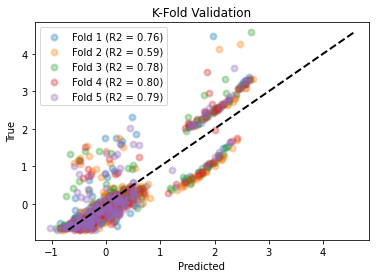

0.7893874197058188


In [30]:
X_train = dt_train[X_names].values
y_train = dt_train["Y"].values
X_test = dt_test[X_names].values
y_test = dt_test["Y"].values

## call model
model = linear_model.LinearRegression()

## K fold validation
scores = []
cv = model_selection.KFold(n_splits=5, shuffle=True)
fig = plt.figure()
i = 1
for train, test in cv.split(X_train, y_train):
    prediction = model.fit(X_train[train],y_train[train]).predict(X_train[test])
    true = y_train[test]
    score = metrics.r2_score(true, prediction)
    scores.append(score)
    plt.scatter(prediction, true, lw=2, alpha=0.3, label='Fold %d (R2 = %0.2f)' % (i,score))
    i = i+1
plt.plot([min(y_train),max(y_train)], [min(y_train),max(y_train)], 
         linestyle='--', lw=2, color='black')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('K-Fold Validation')
plt.legend()
plt.show()

print(score)

In [31]:
#OLS Regression Results
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

lm = LinearRegression()
lm.fit(X_train, y_train)


# Running the linear model 
lm = sm.OLS(y_train,X_train).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.776
Model:                            OLS   Adj. R-squared (uncentered):              0.774
Method:                 Least Squares   F-statistic:                              643.4
Date:                Sat, 10 Apr 2021   Prob (F-statistic):                   4.52e-299
Time:                        07:51:35   Log-Likelihood:                         -711.55
No. Observations:                 936   AIC:                                      1433.
Df Residuals:                     931   BIC:                                      1457.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [32]:
from copy import deepcopy

df = deepcopy(dt)

In [33]:
#White Test for heteroscedastisticity

from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from patsy import dmatrices


df['Time_Period'] = range(1, len(df)+1)

df['LOG_Charges'] = np.log(df['Y'])
expr = 'LOG_Charges ~ Time_Period'

olsr_results = smf.ols(expr, df).fit()

b, A = dmatrices(expr, df, return_type='dataframe')

keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']

results = het_white(olsr_results.resid, A)
lzip(keys, results)

C:\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


[('Lagrange Multiplier statistic:', 5.98845757835873),
 ("LM test's p-value:", 0.050075230758695015),
 ('F-statistic:', 3.0077249730974898),
 ("F-test's p-value:", 0.05007551983408415)]

In [34]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#perform Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value','f-value', 'f p-value']
test = sms.het_breuschpagan(olsr_results.resid, olsr_results.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 6.003951995818433),
 ('p-value', 0.11141811013399583),
 ('f-value', 3.004944880309618),
 ('f p-value', 0.11663863538255281)]

[('Lagrange multiplier statistic', 6.003951995818433),
 ('p-value', 0.11141811013399583),
 ('f-value', 3.004944880309618),
 ('f p-value', 0.11663863538255281)]

In [35]:
#Ramsey Reset Test

import statsmodels.stats.diagnostic as dg

reset = dg.linear_reset(lm, power = 4, test_type = 'fitted', use_f = True, )
print("Ramsey RESET test \n ")
print("F Statistic: ", np.round(reset.fvalue, 4))
print("P Value: ", np.round(reset.pvalue, 4))

Ramsey RESET test 
 
F Statistic:  [[37.7288]]
P Value:  0.0
